The Amazon Fine Food Reviews dataset consisit s of reviews of fine foods from Amazon.

**Objective:**
Given a review ,Determine whether the review is positive (Rating of 4 or 5) or Negative (Rating of 1 to 2).

**Loading The DataSet**

The dataset is availabe in two form


1.   .csv file
2.   SQLite database

In order to load the data, we have used the SQLite dataset as it easier to query the data and visualize the data efficiently.




In [3]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer


In [4]:
con= sqlite3.connect("/content/drive/MyDrive/Amazon Fine Food Review/database.sqlite")

data = pd.read_sql_query("""
SELECT *
FROM Reviews
""",con)
print(data.shape)
data.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#By looking the dataset we can see that

1.Number of datapoint  = 568454

2.Numbere of Attributes/columns/Features = 10

#Featurs look like :

1. Id :identification number.

2. ProductId :Unique identification number for the product.

3. UserId : Unique identification number of the user.

4. ProfileName :Name of the user on Amazon website .

5. HelpfulnessNumerator :Number of "YES"

6. HelpfulnessDenominator :Number of ("YES + No").

7. Score :Score is nothing but the rating in stars

8. Time : time at which message written by the user .

9. Summary : Overall message crucks.

10. Text : Message given by the user for the product.

#Cleaning of the DataSet:
filtering only positive and negative reviews i.e
not taking into consideration those review with score  = 3

In [5]:
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""",con)

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Now we are going to define the function which makes/convert Score into Positive and Negative Reviews.like (1 to 2):-give Negative most of the time and (4 to 5 ) rating most of the time it will give Pesitive Reviews amd for the Rating (3) Score Either it will be Positive/Negative or neutral.so, we are not going to consider this .


In [7]:
def partition(x):
  if x<3:
    return 'negative'
  return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

Now the data look like this :

In [8]:
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Now , the column "Score" value either "positive" or "Negative"

#Data Cleaning:

1.De-duplication.

In [9]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId = 'AR5J8UI46CURR'
ORDER BY ProductID
""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


By Seeing the above dataset we can easily say that dataset contains "dublicate" datapoint.so we need to remove those datapoint which contains dublicasy and redundancy .

In [10]:
#sorting the data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis = 0,ascending = True,inplace =False,kind='quicksort',na_position='last')

In [11]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset ={"UserId","ProfileName","Time","Text"},keep = 'first',inplace = False,ignore_index=True)
final.shape

(364173, 10)

**Analysis**:

By looking the new size of the dataset we can surely say that Amazon Fine Food Review dataset contains sone percentage of Dublication of the data.i.e

%of Dublication = ((525814-364173)/525814)*100 = 30.74%

This means that almost one fourth of the data is dublicate in the Amazon Fine Food Review dataset.

In [12]:
#Checking how much data still remains for the further process
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

Almost we have 70% data of the total dataset which will use for the further data preprocessing .

In [13]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [14]:
display = pd.read_sql("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id = 44737 OR Id = 64422
ORDER BY ProductId
""",con)

print(final.shape)
display

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


As we can see that HelpfulnessDenominator of ProductId=B000MIDROQ is less than the HelpfulnessNuminator. this is totally wrong mathematically why Because as we know that :


1.  HelpfulnessNumirator = no of YES
2.  HelpfulnessDenominator = no of (YES+NO)

this means that HelpfulnessNumerator is less than HelpfulnessDenomirator always.

This problem not only for the one productId it might be chance it may be various ProductId.So we need to sort this problem from our dataset.



In [15]:
print("Before shape of final dataset:",final.shape)
final  = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

Before shape of final dataset: (364173, 10)


(364171, 10)

Analysis: we can see here clearly there is two datapoint which contains this type of problem .

In [16]:
#before going to the next step of Data Preprocessing
print(final.shape)

final['Score'].value_counts()


(364171, 10)


Score
positive    307061
negative     57110
Name: count, dtype: int64

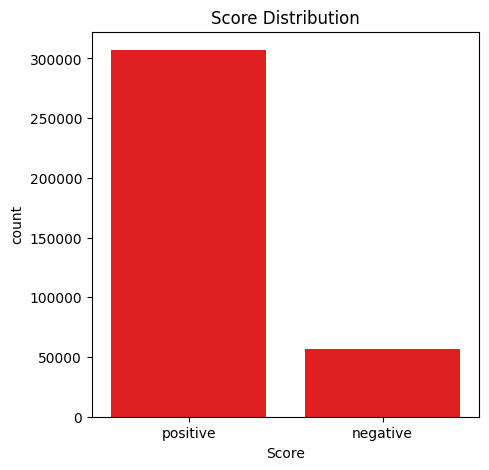

In [17]:
plt.figure(figsize =(5,5))
sns.countplot(x = 'Score',data= final,color ='red')
plt.title("Score Distribution")
plt.show()

Analysis:By looking the score Distribution we can clearly say that our dataset is imbalance dataset.

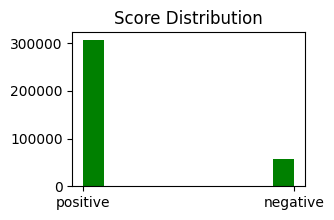

In [18]:
plt.figure(figsize =(3,2))
plt.hist(final['Score'].values,color='green')
plt.title("Score Distribution")
plt.show()

Analysis:Here we can clearly see that the difference between the counts of Positive sentiment and Negative sentiment is huge.That means the Amazon fine food review dataset is Imbalance dataset.

In [19]:
# sns.pairplot(data = final,hue = 'Score')

Analysis:By looking the pair plot we can surely say that our dataset is imbalance dataset.

#Conversion of Text To a Numeric Vector:

1. BoW(Bag of Words).

2. TF-IDF(Term Frequency-Inverse Document Frequency).

3. W2V(Word2Vec).

4. Average W2V(Word2Vec).

5. (TF-IDF)-W2V.

#1. Bag of Words(BoW)

In [20]:
# !pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['Text'].values)

In [21]:
type(final_counts)

scipy.sparse._csr.csr_matrix

In [22]:
final_counts.get_shape()

(364171, 115281)

Analysis: The final_counts is a sparse matrix of dimension (364171,115281).which means


1.   364171->it represents,how many number of reviews/datapoints in the Amazon fine food reviews dataset.

2.   115281->it represent, how many number of Unique words in the each datapoints or the how many unique words present in the each reviews.



In [23]:
final_counts

<364171x115281 sparse matrix of type '<class 'numpy.int64'>'
	with 19341760 stored elements in Compressed Sparse Row format>

In [24]:
# #finding Sparcity of a sparse matrix
# count_K =0
# for i in range(final_counts.shape[0]):
#   for j in range(final_counts.shape[1]):
#     if final_counts[i,j]!=0:
#       count_K = count_K+1

# Sparsity_of_final_count = count_K/(final_counts.shape[0]*final_counts.shape[1])*100
# print("Sparsity of the fianl_counts of sparse matric:",Sparsity_of_final_count)




#Text Preprocessing :Stemming,Stop-Word removal and Lemmatization.

=>During Preprocessing of the text we are following some simple steps.

1. Begin by removal of the html tags.

2. Remove any punctuation or limited set of interval characters like or,# etc.

3. checking for the Alpha-numeric
4. Checking the length of the letter is more than two or not .
5. Convert the words into the lowercase.
6. Removal of stopWords.
7. Snowball/Porter Stemming of word Algorithm.


In [26]:
#1. finding sentences containing HTML tags.
import re #regular expression
i = 0;
for sent in final['Text'].values:
  if(len(re.findall('<.*?',sent))):
    print(i)
    print(sent)
    break;
  i = i+1;


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [29]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
sno = PorterStemmer()
wordnet = WordNetLemmatizer()

def cleanhtml(sentence):
  cleanr =re.compile('<.*?>')
  cleantext = re.sub(cleanr,'',sentence)
  return cleantext

def cleanpunc(sentence):
  cleaned = re.sub(r'[?|!|\|"|#]',r'',sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
  return cleaned

print(stop)
print('********************************')
print(sno.stem('tasty'))

{'each', 're', 'haven', 'up', "wasn't", "you're", 'any', 'them', 'than', 'if', "you'll", 'your', 'him', 'then', 'why', 'or', 'do', 'himself', 'so', 'what', 'be', 'off', 've', "she's", 'myself', 's', 'other', "should've", 'own', 'our', 'they', 'theirs', 'having', "it's", "won't", "that'll", 'does', 'his', 'more', 'weren', 'because', 'a', 'where', 'is', 'itself', 'into', "you've", 'until', 'did', 'over', 'hers', 'doing', 'shouldn', 'my', 'wasn', 'll', 'should', 'hasn', 'yourself', 'nor', "mustn't", 'not', 'after', 'am', 'can', 'once', 'down', 'don', 'o', "needn't", 'during', 'was', "shan't", 'that', 'whom', 'being', 'have', 'here', 'couldn', 'under', 'has', 'ma', 'these', 'it', 'i', 'needn', "didn't", 'those', 'most', 'were', 'some', 'how', 'yours', 'above', 'to', "haven't", 'themselves', "couldn't", 'their', 'who', 'while', 'hadn', 'won', 'mightn', 'but', 'of', 'both', 'you', 'only', "doesn't", 'against', 'y', 'had', 'will', 'we', 'such', 'as', 'didn', 'which', 'before', 'very', 'are', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
i =0;
strl = ''
final_string = []
all_positive_words = []
all_negative_words =[]
s = ''
for sent in final['Text'].values:
  filtered_sentence =[]
  #print(sent)
  sent =cleanhtml(sent)
  for w in sent.split():
    for cleaned_words in cleanpunc(w).split():
      if((cleaned_words.isalpha())& (len(cleaned_words)>2)):
        if(cleaned_words.lower() not in stop):
          s = (sno.stem(cleaned_words.lower())).encode('utf8')
          filtered_sentence.append(s)
          # Moved the conditional checks outside the loop
          if(final['Score'].values[i]=='positive'):
            all_positive_words.append(s)
          if(final['Score'].values[i]=='negative'):
            all_negative_words.append(s)

        else:
          continue
    else:
      continue
    #print(filtered_sentences)
    # Convert the list of bytes to a single byte string
    if filtered_sentence:  # Check if filtered_sentence is not empty
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
    else:
        final_string.append(b'') # Append an empty byte string if no words are found
    print("***********************************************************")

  # Increment the index 'i' after processing each sentence
  i = i+1

# Handle potential length mismatch after the loop
if len(final_string) < len(final):
    final_string += [b''] * (len(final) - len(final_string))

final['CleanedText'] = final_string
final.head(3)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b''
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b''
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b''


In [37]:
#store final table into an SQLite table for the future implementation
conn = sqlite3.connect('final.sqlite')
c =conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn,schema = None,if_exists='replace',
             index = True,index_label =None,
             chunksize = None,dtype =None)



364171

#Now We are going to appy Bi-Gram and N-Gram
==>To understand the concept of word frequency distribution with the help of bi_gram and the N_gram

In [39]:
freq_dist_positive = nltk.FreqDist(all_positive_words)
freq_dist_negative =nltk.FreqDist(all_negative_words)
print("Most common Positive Words:",freq_dist_positive.most_common(20))
print("Most Common Positive Words: ",freq_dist_negative.most_common(20))

Most common Positive Words: [(b'like', 138317), (b'tast', 125929), (b'good', 109735), (b'love', 106433), (b'flavor', 106267), (b'use', 102847), (b'great', 100414), (b'one', 93825), (b'product', 88276), (b'tri', 85096), (b'tea', 81348), (b'coffe', 76246), (b'make', 74439), (b'get', 71647), (b'food', 62863), (b'would', 55116), (b'buy', 53550), (b'time', 53533), (b'realli', 52384), (b'eat', 51295)]
Most Common Positive Words:  [(b'tast', 33813), (b'like', 32051), (b'product', 27313), (b'one', 20064), (b'flavor', 18864), (b'would', 17856), (b'tri', 17512), (b'use', 15136), (b'good', 14594), (b'coffe', 14222), (b'get', 13703), (b'buy', 13603), (b'order', 12695), (b'food', 12331), (b'tea', 11288), (b'even', 10884), (b'box', 10542), (b'make', 9784), (b'time', 9555), (b'bag', 9467)]


**Observation:**:=From the above it can be seen that the most common positive and negative word:Eg ='like' or 'not like' etc

so, it is good idea to consider the pair of words (bi-grams) or k-Sequence of the n-consecutive words(n-grams)

In [ ]:
#code
count_vect =CountVectorizer(ngram_range =(1,2))
final_Bi_gram_counts =count_vect.fit_transform(final['Text'].values)
